# NeuralTreeNet et coût

La classe *NeuralTreeNet* convertit un arbre de décision en réseau de neurones. Si la conversion n'est pas exacte mais elle permet d'obtenir un modèle différentiable et apprenable avec un algorithme d'optimisation à base de gradient. Ce notebook compare le temps d'éxécution entre un arbre et le réseau de neurones.

In [2]:
%matplotlib inline

In [3]:
%load_ext mlprodict

## Jeux de données

On construit un jeu de données aléatoire.

In [4]:
import numpy

X = numpy.random.randn(10000, 10)
y = X.sum(axis=1) / X.shape[1]
X = X.astype(numpy.float64)
y = y.astype(numpy.float64)

In [5]:
middle = X.shape[0] // 2
X_train, X_test = X[:middle], X[middle:]
y_train, y_test = y[:middle], y[middle:]

## Caler un arbre de décision

In [6]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=7)
tree.fit(X_train, y_train)
tree.score(X_train, y_train), tree.score(X_test, y_test)

(0.6091161526814477, 0.3884519134946681)

In [7]:
from sklearn.metrics import r2_score

r2_score(y_test, tree.predict(X_test))

0.3884519134946681

Covnersion de l'arbre en réseau de neurones

In [8]:
from pandas import DataFrame
from mlstatpy.ml.neural_tree import NeuralTreeNet, NeuralTreeNetRegressor

xe = X_test.astype(numpy.float32)
expected = tree.predict(xe)

nn = NeuralTreeNetRegressor(NeuralTreeNet.create_from_tree(tree, arch="compact"))
got = nn.predict(xe)
me = numpy.abs(got - expected).mean()
mx = numpy.abs(got - expected).max()
DataFrame([{"average absolute error": me, "max absolute error": mx}]).T

,0
average absolute error,0.210314
max absolute error,1.679553


La conversion est loin d'être parfaite. La raison vient du fait que les fonctions de seuil sont approchées par des fonctions sigmoïdes. Il suffit d'une erreur minime pour que la décision prenne un chemin différent dans l'arbre et soit complètement différente.

## Conversion au format ONNX

In [9]:
from skl2onnx import to_onnx

onx_tree = to_onnx(tree, X[:1].astype(numpy.float32))
onx_nn = to_onnx(nn, X[:1].astype(numpy.float32))

Le réseau de neurones peut être représenté comme suit.

In [10]:
%onnxview onx_nn

In [11]:
from onnx_array_api.plotting.text_plot import onnx_simple_text_plot

print(onnx_simple_text_plot(onx_nn))

opset: domain='' version=15
input: name='X' type=dtype('float32') shape=[None, 10]
init: name='Ma_MatMulcst' type=dtype('float32') shape=(1270,)
init: name='Ad_Addcst' type=dtype('float32') shape=(127,)
init: name='Mu_Mulcst' type=dtype('float32') shape=(1,) -- array([4.], dtype=float32)
init: name='Ma_MatMulcst1' type=dtype('float32') shape=(16256,)
init: name='Ad_Addcst1' type=dtype('float32') shape=(128,)
init: name='Ma_MatMulcst2' type=dtype('float32') shape=(128,)
init: name='Ad_Addcst2' type=dtype('float32') shape=(1,) -- array([0.], dtype=float32)
MatMul(X, Ma_MatMulcst) -> Ma_Y02
  Add(Ma_Y02, Ad_Addcst) -> Ad_C02
    Mul(Ad_C02, Mu_Mulcst) -> Mu_C01
      Sigmoid(Mu_C01) -> Si_Y01
        MatMul(Si_Y01, Ma_MatMulcst1) -> Ma_Y01
          Add(Ma_Y01, Ad_Addcst1) -> Ad_C01
            Mul(Ad_C01, Mu_Mulcst) -> Mu_C0
              Sigmoid(Mu_C0) -> Si_Y0
                MatMul(Si_Y0, Ma_MatMulcst2) -> Ma_Y0
                  Add(Ma_Y0, Ad_Addcst2) -> Ad_C0
                    Ide

## Temps de calcul des prédictions

In [12]:
from onnxruntime import InferenceSession

oinf_tree = InferenceSession(onx_tree.SerializeToString())
oinf_nn = InferenceSession(onx_nn.SerializeToString())

%timeit tree.predict(xe)

No CUDA runtime is found, using CUDA_HOME='C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.5'
518 µs ± 41.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [13]:
%timeit oinf_tree.run(None, {'X': xe})

124 µs ± 5.21 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [14]:
%timeit oinf_nn.run(None, {'X': xe})

3.18 ms ± 569 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Le temps de calcul est nettement plus long pour le réseau de neurones. Si l'arbre de décision a une profondeur de *d*, l'arbre de décision va faire exactement *d* comparaisons. Le réseau de neurones quant à lui évalue tous les seuils pour chaque prédiction, soit $2^d$. Vérifions cela en faisant variable la profondeur.

## Temps de calcul en fonction de la profondeur

In [15]:
from tqdm import tqdm
from onnx_array_api.ext_test_case import measure_time

data = []
for d in tqdm(range(2, 10)):
    tree = DecisionTreeRegressor(max_depth=d)
    tree.fit(X_train, y_train)
    obs = measure_time(lambda tree=tree: tree.predict(xe), number=20, repeat=20)
    obs.update(dict(d=d, exp="skl"))
    data.append(obs)

    nn = NeuralTreeNetRegressor(NeuralTreeNet.create_from_tree(tree, arch="compact"))

    onx_tree = to_onnx(tree, X[:1].astype(numpy.float32))
    onx_nn = to_onnx(nn, X[:1].astype(numpy.float32))
    oinf_tree = InferenceSession(
        onx_tree.SerializePartialToString(), providers=["CPUExecutionProvider"]
    )
    oinf_nn = InferenceSession(
        onx_nn.SerializePartialToString(), providers=["CPUExecutionProvider"]
    )

    obs = measure_time(
        lambda oinf_tree=oinf_tree: oinf_tree.run(None, {"X": xe}), number=10, repeat=10
    )
    obs.update(dict(d=d, exp="onx_tree"))
    data.append(obs)

    obs = measure_time(
        lambda oinf_nn=oinf_nn: oinf_nn.run(None, {"X": xe}), number=10, repeat=10
    )
    obs.update(dict(d=d, exp="onx_nn"))
    data.append(obs)

df = DataFrame(data)
df

100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


,average,deviation,min_exec,max_exec,repeat,number,ttime,context_size,d,exp
0,0.005656,0.001292,0.004990,0.009533,20,20,0.113116,64,2,skl
1,0.000609,0.000084,0.000538,0.000830,10,10,0.006088,64,2,onx_tree
2,0.002337,0.000563,0.001737,0.003299,10,10,0.023374,64,2,onx_nn
3,0.005607,0.000962,0.004669,0.007374,20,20,0.112131,64,3,skl
4,0.000709,0.000240,0.000534,0.001363,10,10,0.007087,64,3,onx_tree
5,0.002506,0.000448,0.002073,0.003736,10,10,0.025064,64,3,onx_nn
6,0.006398,0.000942,0.005576,0.009556,20,20,0.127961,64,4,skl
7,0.000852,0.000335,0.000633,0.001715,10,10,0.008519,64,4,onx_tree
8,0.004151,0.000763,0.003408,0.005826,10,10,0.041507,64,4,onx_nn
9,0.007266,0.000731,0.006400,0.009247,20,20,0.145314,64,5,skl


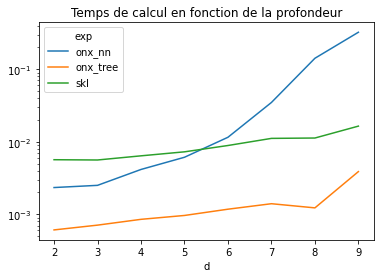

In [16]:
piv = df.pivot("d", "exp", "average")
piv.plot(logy=True, title="Temps de calcul en fonction de la profondeur");

L'hypothèse est vérifiée.